In [1]:
!nvidia-smi

Fri Apr 12 01:27:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce MX150           On  | 00000000:01:00.0 Off |                  N/A |
| N/A   39C    P8              N/A / ERR! |    108MiB /  2048MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import torch

torch.cuda.get_device_name(0)

'NVIDIA GeForce MX150'

In [3]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

2.2.2
11.8
True


## Karate

(undirected and unweighted)

In [4]:
def print_dataset_info(dataset):
    print(f"Dataset: {dataset}")
    print(f"Number of samples: {len(dataset)}")
    print(f"Number of features: {dataset.num_features}")
    print(f"Number of classes: {dataset.num_classes}")

In [5]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print_dataset_info(dataset)

Dataset: KarateClub()
Number of samples: 1
Number of features: 34
Number of classes: 4


In [6]:
G = dataset[0]
G

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])

In [7]:
G.x

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [8]:
G.y

tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])

In [9]:
G.train_mask

tensor([ True, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False])

In [10]:
G.num_nodes

34

In [11]:
G.edge_index

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
         33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33],
        [ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  0,  2,
          3,  7, 13, 17, 19, 21, 30,  0,  1,  3,  7,  8,  9, 13, 27, 28, 32,  0,
          1,  2,  7, 12, 13,  0,  6, 10,  0,  6, 10, 16,  0,  4,  5, 16,  0,  1,
          2,  3,  0,  2, 30, 32, 33,  2, 33,  0,  4

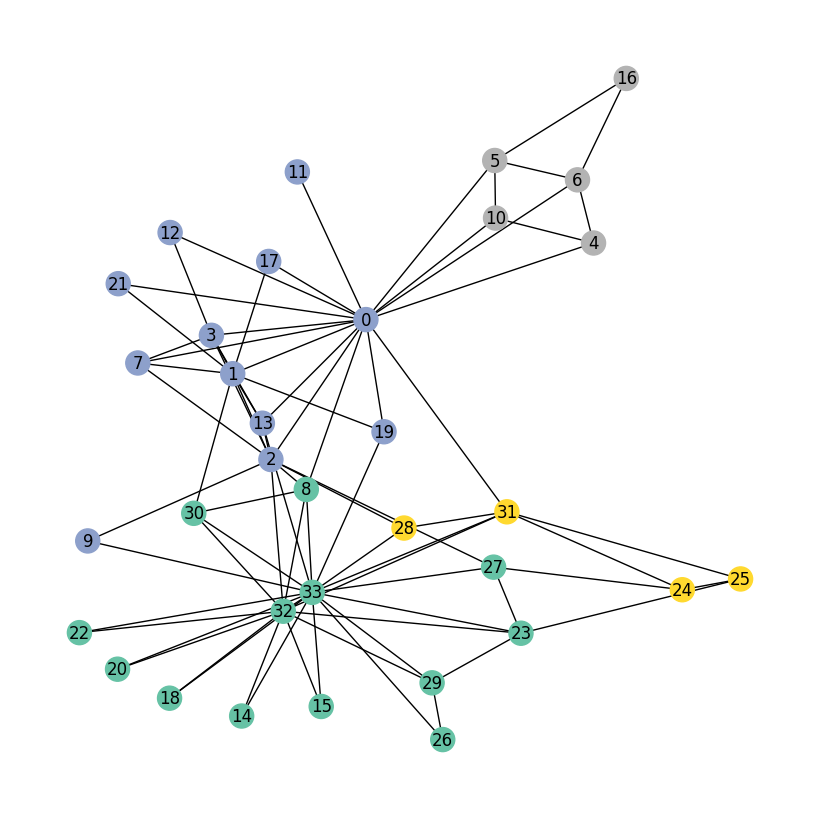

In [12]:
# Visualize the dataset

import networkx as nx
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))

# Create an adjacency matrix
adjacency_matrix = torch.zeros(G.num_nodes, G.num_nodes)
adjacency_matrix[G.edge_index[0], G.edge_index[1]] = 1

# Convert the adjacency matrix to numpy
adjacency_matrix_np = adjacency_matrix.numpy()

# Now create the graph
nx_G = nx.Graph(adjacency_matrix_np)
pos = nx.spring_layout(nx_G, seed=42)
colors = G.y.numpy()

nx.draw(nx_G, pos, with_labels=True, node_color=colors, cmap="Set2")
plt.show()

In [13]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [47]:
from torch_geometric.utils import train_test_split_edges
from torch_geometric.transforms import RandomLinkSplit, RandomNodeSplit

x_train = G.x[G.train_mask]
y_train = G.y[G.train_mask]

# Create a new graph with filtered nodes (and edges)
# train_test_split_edges is obsolete
train_data, val_data, test_data = RandomLinkSplit(num_val=0, is_undirected=True, num_test=0.2)(G)  # Split edges for train/test

train_data, val_data, test_data

(Data(x=[34, 34], edge_index=[2, 126], y=[34], train_mask=[34], edge_label=[126], edge_label_index=[2, 126]),
 Data(x=[34, 34], edge_index=[2, 126], y=[34], train_mask=[34], edge_label=[0], edge_label_index=[2, 0]),
 Data(x=[34, 34], edge_index=[2, 126], y=[34], train_mask=[34], edge_label=[30], edge_label_index=[2, 30]))

In [37]:
test_data.edge_label_index

tensor([[ 1, 14,  3, 23,  4,  1, 28, 27, 26,  9, 30,  0, 23,  9, 17, 10, 19, 17,
         29, 19],
        [ 2, 32,  7, 27,  6, 19, 33, 33, 33, 33, 16, 32,  1, 27, 10, 31,  8, 24,
         18, 17]])

In [38]:
# show difference between test_data.edge_index, train_data.edge_index

print(test_data.edge_label_index.size())
print(train_data.edge_label_index.size())

print(train_data.edge_label_index[0].bincount())
print(test_data.edge_label_index[0].bincount())

torch.Size([2, 20])
torch.Size([2, 136])
tensor([17,  8,  9,  3,  1, 10,  6,  0,  6,  4,  5,  3,  1,  1,  2,  2,  2,  1,
         2,  6,  3,  4,  6,  5,  6,  1,  2,  2,  4,  3,  4,  5,  2])
tensor([1, 2, 0, 1, 1, 0, 0, 0, 0, 2, 1, 0, 0, 0, 1, 0, 0, 2, 0, 2, 0, 0, 0, 2,
        0, 0, 1, 1, 1, 1, 1])


In [28]:
train_data.edge_label_index

tensor([[33, 13, 32, 33, 33, 10,  5,  7, 29,  0, 23, 12,  4,  6, 23, 24,  9,  0,
          5,  1, 14,  9, 22, 27, 33, 33, 33, 32, 33, 22, 31,  3, 30,  2,  6, 26,
         13, 32,  7, 10, 11,  3,  8, 23, 15,  1, 33, 21,  2, 23, 24, 24, 33, 31,
         31, 32, 17,  0,  0, 32,  0,  3, 32, 32,  8, 19, 33, 29, 32, 33,  0,  3,
          1,  4, 14,  0, 23,  1, 13, 28, 18,  8, 33, 32, 27,  2, 25, 31,  5,  2,
         33, 31, 25,  0, 33, 29, 32, 28, 20, 26,  3,  2,  0, 25,  1, 30, 10, 20,
         32,  4, 29,  6, 27,  8, 27,  0,  0, 19,  2,  0,  8,  2,  7,  0, 17, 32,
         30, 13,  2, 16, 21,  2,  6, 31,  0,  3, 22, 19, 14, 16, 20, 21,  4, 32,
         24, 11, 19, 17, 17, 25, 20,  6, 27, 19,  5, 12, 28,  1, 20, 22, 14, 27,
          5, 23, 30, 23, 13,  8, 17, 11,  8,  1, 30,  4, 11,  5, 23, 11,  6, 26,
         28,  0,  6, 13,  4, 12,  1, 33, 30, 15, 13, 32,  4, 22, 12, 29, 25, 32,
          8, 20, 15, 25, 31, 30,  4, 29,  2, 24, 14, 19, 24,  9, 27, 25,  1, 25,
         11,  6,  8, 16, 14,

In [15]:
# check if train mask of train_data, val_data, test_data are the same
equal = torch.equal(train_data.train_mask, val_data.train_mask) and torch.equal(val_data.train_mask, test_data.train_mask)
print(equal)

True


In [16]:
model = GCN(in_channels=-1, hidden_channels=64, out_channels=G.num_features)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
model.train()
for epoch in range(1000):
    optimizer.zero_grad()
    out = model(train_data.x, train_data.edge_index)
    loss = criterion(out[train_data.train_mask], train_data.y[train_data.train_mask])
    loss.backward()
    optimizer.step()

    acc = (out[train_data.train_mask].argmax(dim=-1) == train_data.y[train_data.train_mask]).sum().item() / train_data.train_mask.sum().item()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss {loss.item()} | Accuracy {acc}")

Epoch 0 | Loss 3.525134325027466 | Accuracy 0.0
Epoch 10 | Loss 1.9490920305252075 | Accuracy 0.5
Epoch 20 | Loss 0.9819196462631226 | Accuracy 0.5
Epoch 30 | Loss 0.47586095333099365 | Accuracy 1.0
Epoch 40 | Loss 0.23996007442474365 | Accuracy 1.0
Epoch 50 | Loss 0.17178940773010254 | Accuracy 1.0
Epoch 60 | Loss 0.054356805980205536 | Accuracy 1.0
Epoch 70 | Loss 0.017003964632749557 | Accuracy 1.0
Epoch 80 | Loss 0.01054210215806961 | Accuracy 1.0
Epoch 90 | Loss 0.009772317484021187 | Accuracy 1.0
Epoch 100 | Loss 0.015764854848384857 | Accuracy 1.0
Epoch 110 | Loss 0.013758964836597443 | Accuracy 1.0
Epoch 120 | Loss 0.011846538633108139 | Accuracy 1.0
Epoch 130 | Loss 0.004655392374843359 | Accuracy 1.0
Epoch 140 | Loss 0.007475218735635281 | Accuracy 1.0
Epoch 150 | Loss 0.003475119825452566 | Accuracy 1.0
Epoch 160 | Loss 0.0027104183100163937 | Accuracy 1.0
Epoch 170 | Loss 0.0032575675286352634 | Accuracy 1.0
Epoch 180 | Loss 0.00590283889323473 | Accuracy 1.0
Epoch 190 | Lo

In [17]:
# Evaluation loop

model.eval()

with torch.no_grad():
    out = model(test_data.x, test_data.edge_index)
    loss = criterion(out, test_data.y)
    acc = (out.argmax(dim=-1) == test_data.y).sum().item() / test_data.y.size(0)

    print(f"Test Loss {loss.item()} | Test Accuracy {acc}")

Test Loss 0.5267931222915649 | Test Accuracy 0.8235294117647058


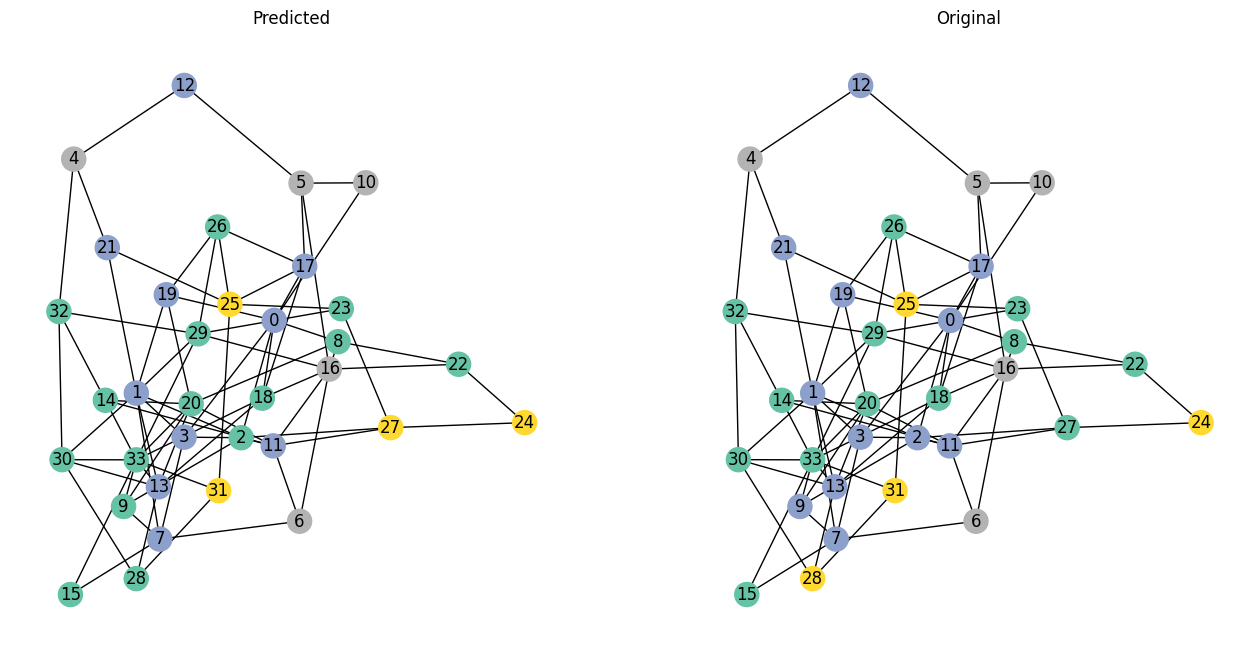

In [48]:
# show result and original graphs side by side

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
colors = out.argmax(dim=-1).numpy()
nx.draw(nx_G, pos, with_labels=True, node_color=colors, cmap="Set2")
plt.title("Predicted")

plt.subplot(1, 2, 2)
colors = G.y.numpy()
nx.draw(nx_G, pos, with_labels=True, node_color=colors, cmap="Set2")
plt.title("Original")

plt.show()

In [19]:
# show difference between test_data.edge_index, train_data.edge_index

print(test_data.edge_index.size())
print(train_data.edge_index.size())

print(train_data.edge_index[0].bincount())
print(test_data.edge_index[0].bincount())

torch.Size([2, 136])
torch.Size([2, 136])
tensor([14,  5,  9,  6,  3,  3,  4,  3,  5,  2,  3,  1,  1,  4,  2,  1,  1,  2,
         1,  2,  2,  2,  2,  5,  3,  3,  2,  4,  2,  4,  3,  6, 12, 14])
tensor([14,  5,  9,  6,  3,  3,  4,  3,  5,  2,  3,  1,  1,  4,  2,  1,  1,  2,
         1,  2,  2,  2,  2,  5,  3,  3,  2,  4,  2,  4,  3,  6, 12, 14])


In [20]:
def generate_adjacency_matrix(num_nodes, edge_index):
    adjacency_matrix = torch.zeros(num_nodes, num_nodes)
    adjacency_matrix[edge_index[0], edge_index[1]] = 1
    return adjacency_matrix.numpy()

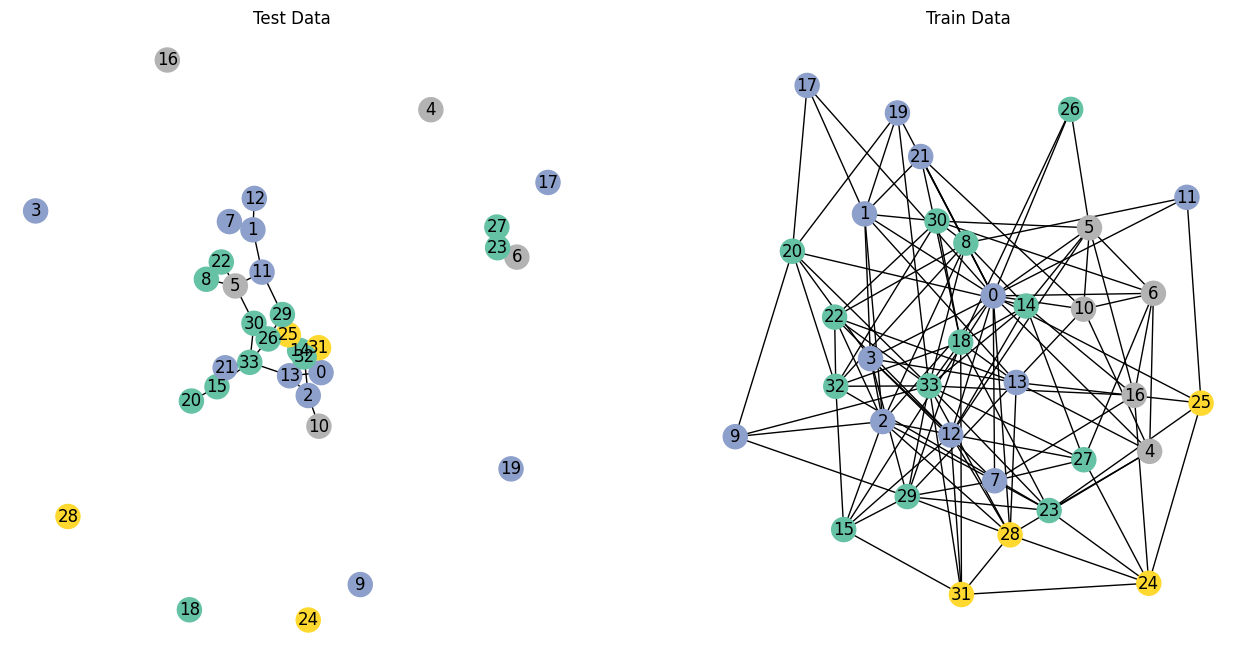

In [49]:
# Visualize the dataset

import networkx as nx
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))


plt.subplot(1, 2, 1)
adjacency_matrix_np = generate_adjacency_matrix(G.num_nodes, test_data.edge_label_index)
nx_G = nx.Graph(adjacency_matrix_np)
pos = nx.spring_layout(nx_G, seed=42)
colors = G.y.numpy()
nx.draw(nx_G, pos, with_labels=True, node_color=colors, cmap="Set2")

plt.title("Test Data")

plt.subplot(1, 2, 2)
adjacency_matrix_np = generate_adjacency_matrix(G.num_nodes, train_data.edge_label_index)
nx_G = nx.Graph(adjacency_matrix_np)
pos = nx.spring_layout(nx_G, seed=42)
colors = G.y.numpy()
nx.draw(nx_G, pos, with_labels=True, node_color=colors, cmap="Set2")

plt.title("Train Data")

plt.show()

In [22]:
# test on the whole graph

model.eval()

with torch.no_grad():
    out = model(G.x, G.edge_index)
    loss = criterion(out, G.y)
    acc = (out.argmax(dim=-1) == G.y).sum().item() / G.y.size(0)

    print(f"Test Loss {loss.item()} | Test Accuracy {acc}")

Test Loss 0.4526953399181366 | Test Accuracy 0.8823529411764706


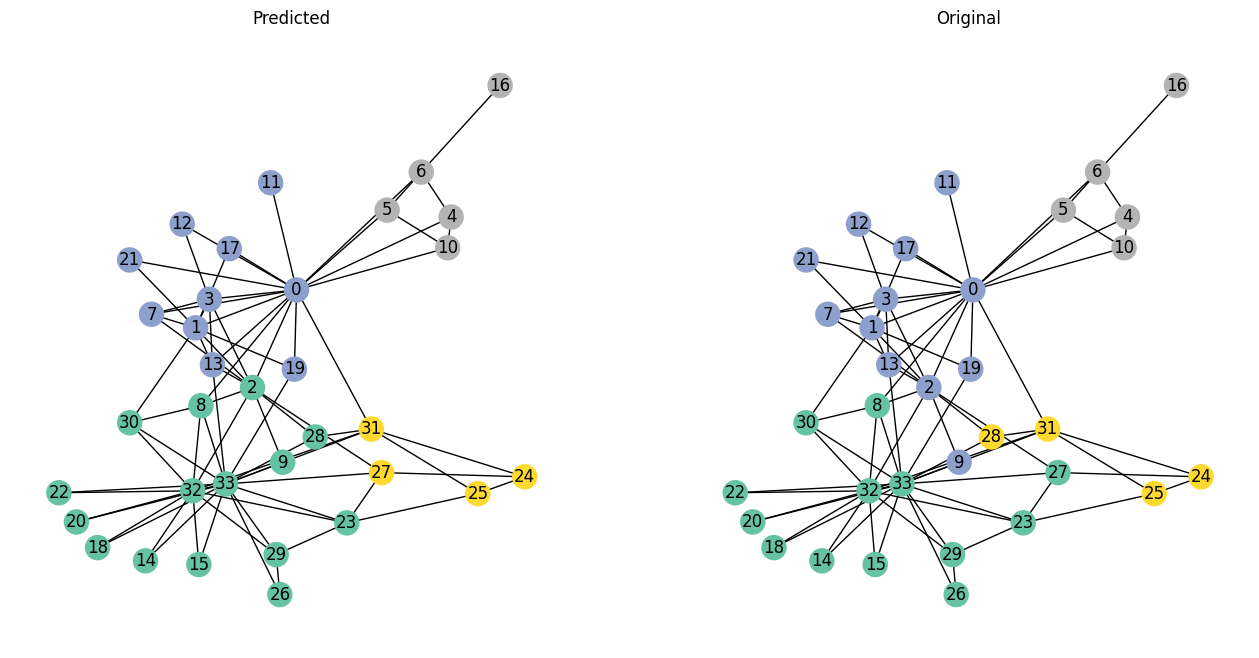

In [23]:
# show result and original graphs side by side

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
colors = out.argmax(dim=-1).numpy()
nx.draw(nx_G, pos, with_labels=True, node_color=colors, cmap="Set2")
plt.title("Predicted")

plt.subplot(1, 2, 2)
colors = G.y.numpy()
nx.draw(nx_G, pos, with_labels=True, node_color=colors, cmap="Set2")
plt.title("Original")

plt.show()

In [24]:
# xxx = RandomNodeSplit(num_test=5, num_val=0)(G)

# xxx.train_mask, xxx.val_mask, xxx.test_mask

In [25]:
# model = GCN(in_channels=xxx.x.size(-1), hidden_channels=64, out_channels=xxx.num_features)

# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# criterion = torch.nn.CrossEntropyLoss()

# # Training loop
# model.train()
# for epoch in range(1000):
#     optimizer.zero_grad()
#     out = model(xxx.x, xxx.edge_index)
#     loss = criterion(out[xxx.train_mask], xxx.y[xxx.train_mask])
#     loss.backward()
#     optimizer.step()

#     acc = (out[xxx.train_mask].argmax(dim=-1) == xxx.y[xxx.train_mask]).sum().item() / xxx.train_mask.sum().item()

#     if epoch % 10 == 0:
#         print(f"Epoch {epoch} | Loss {loss.item()} | Accuracy {acc}")
        

In [26]:
# # Evaluation loop

# model.eval()

# with torch.no_grad():
#     out = model(xxx.x, xxx.edge_index)
#     loss = criterion(out[xxx.test_mask], xxx.y[xxx.test_mask])
#     acc = (out[xxx.test_mask].argmax(dim=-1) == xxx.y[xxx.test_mask]).sum().item() / xxx.test_mask.sum().item()

#     print(f"Test Loss {loss.item()} | Test Accuracy {acc}")

In [27]:
# # show only nodes that are in the test set

# plt.figure(figsize=(16, 8))

# plt.subplot(1, 2, 1)

